## Improving Memory Search

### Setup

In [1]:
# imports for analyses
import csv
import math
import scipy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, ttest_rel
from scipy import spatial
from matplotlib import gridspec
from matplotlib.lines import Line2D
from mycolorpy import colorlist as mcp
cset=mcp.gen_color(cmap="inferno",n=8)

In [2]:
# obtain human data details
exp='data/finaldata_opt/'
data_id=2 #data_id indicates folder for functions_overrides.py to use
ll = 16   #list length
ntrials_persub = 12 #number of expeirmental trials
recall_time = 90000 #ms

# only included trials, following exclusion criteria (see Methods):
recs_amts_data = np.loadtxt(exp+'/recs_amts.txt',delimiter=',') #initial recall amount by trial
cue_times_data = np.loadtxt(exp+'/cue_times.txt',delimiter=',') #cue request time into the 90 seconds
rmdr_idxs_data = np.loadtxt(exp+'/rmdr.txt',delimiter=',')      #index of cue in remaining word list
post_amts_data = np.loadtxt(exp+'/post_rmdr_amt.txt',delimiter=',')   #post-cue recall amount by trial

ntrials = len(recs_amts_data) #number of included trials
ntrials_all = len(np.loadtxt(exp+'/pres_all.txt',delimiter=',').tolist()) #total collected trials
nsubjects = int(ntrials_all/ntrials_persub) #number of subjects overall

print("\n\033[1m --- HUMAN DATA DETAILS --- \n\033[0m")
print(" *",nsubjects,"subjects included in analyses")
print(" *",ntrials,"cued trials out of",ntrials_all,"total trials are included")
print(" * Cue time M = %.1f, SD = %.1f seconds"%(np.mean(cue_times_data)/1000,np.std(cue_times_data)/1000))
print(" * Pre-cue recall M = %.2f, SD = %.2f seconds"%(np.mean(recs_amts_data),np.std(recs_amts_data)))
print(" * Totalled recall M = %.2f, SD = %.2f seconds"%(np.mean(recs_amts_data)+np.mean(post_amts_data),
                                                        np.std(recs_amts_data) + np.std(post_amts_data)))


 --- HUMAN DATA DETAILS --- 

 * 195 subjects included in analyses
 * 1524 cued trials out of 2340 total trials are included
 * Cue time M = 44.0, SD = 17.2 seconds
 * Pre-cue recall M = 8.47, SD = 2.92 seconds
 * Totalled recall M = 9.27, SD = 4.05 seconds


### <p></p>

### Simulate Model

In [3]:
# import CMR code
from probCMR_overrides import CMR2Reminder
from functions_overrides import FunctionsReminder
functions = FunctionsReminder()


# simulate CMR   
# CMR_sp: serial positions of items recalled during initial recall (if N=1: matches empirical data)
# reminders: serial positions of remaining items (ordered by their wordpool index value)
# recalls: serial positions of items recalled post-cue (only for last repetition of reminder session)
# accs: recall gain for every repetition of reminder session
# pcas: row for each item; columns 0&1 is temporal context, columns 2&3 is semantic context
# pcas2: row for each item; columns 0&1 are combined temporal and semantic context (ie., encoding context)
# net_cs: encoding context vector for every item (ordered by presentation list order in each trial)
CMR_sp,reminders,recalls,accs,pcas,pcas2,net_cs = functions.model_probCMR(N=1,ll=ll,lag_examine=4,data_id=data_id)


# correct for an indexing difference from data and CMR output by finding shown reminder index in CMR's output 
# (as data files are ordered by serial position whereas CMR is order by wordpool index of the shown words
rmdr_idxs_CMR = []; indx = 0
for r in rmdr_idxs_data: 
    r = int(r.item())                        # index in remaining word list in data, ordered by presentation list
    #print(reminders[indx])                  # the serial positions remaining, ordered by wordpool index
    rem_sorted = np.sort(reminders[indx])    # the serial positions remaining, ordered by pres index
    this_reminder = int(rem_sorted[r])       # corresponding sp value
    r = reminders[indx].index(this_reminder) # index of reminder in CMR's sorted list
    rmdr_idxs_CMR.append(r)
    indx+=1
    

# get CMR's average performance gain from cues
post_amts_CMRA = []
for i in range(len(accs)):
    acc = [np.mean(x) for x in accs[i]]
    post_amts_CMRA.append(acc[rmdr_idxs_CMR[i]])

### <p></p>

### <p></p>

### Extending CMR for Cued Memory Search (Figure 2)

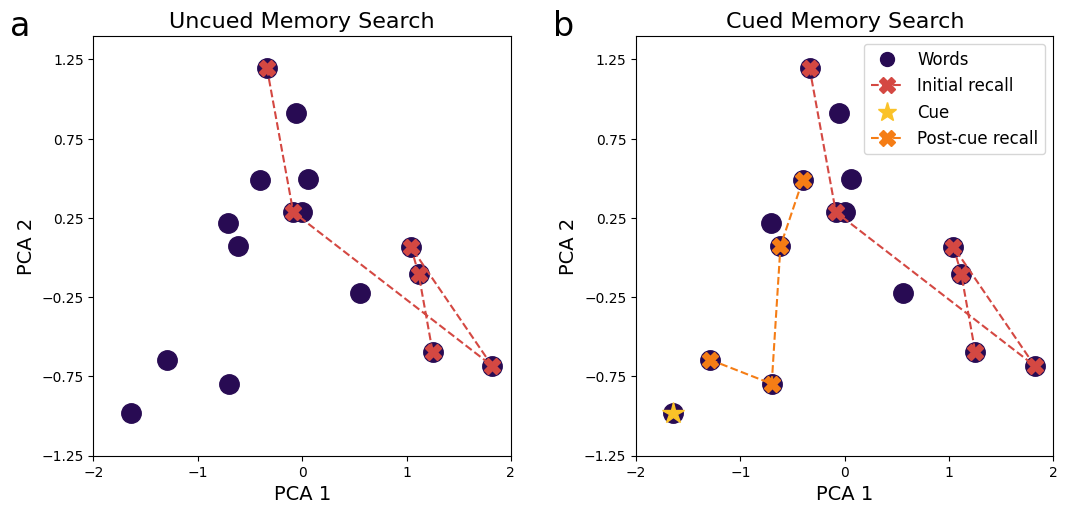

In [16]:
cset=mcp.gen_color(cmap="inferno",n=8)
plt_cs = [cset[4],cset[1],cset[6],cset[5]]

for number in [418]: #which trial(s) to print

    # list of words
    fig, axs = plt.subplots(figsize=(12,6), nrows=1,ncols=2)
    for p in range(2): axs[p].plot(pcas2[number][:,0],pcas2[number][:,1],'o',ms=14,c=plt_cs[1])

    # initial recall
    initial_pca1 = []; initial_pca2 = []
    for i in CMR_sp[number]: initial_pca1.append(pcas2[number][i,0]); initial_pca2.append(pcas2[number][i,1])
    for p in range(2): axs[p].plot(initial_pca1,initial_pca2,'--X',ms=12,c=plt_cs[0])

    # reminder
    i_rem = rmdr_idxs_CMR[number] #index in CMR of shown reminder on trial
    axs[1].plot(pcas2[number][reminders[number][i_rem],0],
                pcas2[number][reminders[number][i_rem],1],'*',ms=16,c=plt_cs[2])

    # reminder session
    reminder_pca1 = []; reminder_pca2 = []
    # actual code
    #for i in recalls[number][i_rem]: 
        #reminder_pca1.append(pcas2[number][i,0])
        #reminder_pca2.append(pcas2[number][i,1])
    # temporally replace with this to match figure in original submission
    reminder_pca1 = [pcas2[number][14,0],
                      pcas2[number][5,0],
                      pcas2[number][10,0],
                      pcas2[number][11,0]]
    reminder_pca2 = [pcas2[number][14,1],
                      pcas2[number][5,1],
                      pcas2[number][10,1],
                      pcas2[number][11,1]]
    axs[1].plot(reminder_pca1,reminder_pca2,'--X',ms=12,c=plt_cs[3])

    # notation
    axs[0].set_title('Uncued Memory Search',fontsize=16); axs[1].set_title('Cued Memory Search',fontsize=16)
    axs[0].text(-0.2, 1, 'a', transform=axs[0].transAxes, size=24)
    axs[1].text(-0.2, 1, 'b', transform=axs[1].transAxes, size=24)
    for p in range(2): 
        axs[p].set_xlabel('PCA 1',fontsize=14); axs[p].set_ylabel('PCA 2',fontsize=14)
        axs[p].set_xticks([x-2 for x in range(5)],fontsize=16)
        axs[p].set_yticks([-1.25,-.75,-.25,.25,.75,1.25],fontsize=16)
        axs[p].axis([-2,2,-1.25,1.4])

    # legend
    legend_elements = [ Line2D([0],[0],marker='o',ms=10,color=plt_cs[1],ls='None',label='Words'),
                        Line2D([0],[0],marker='X',ms=12,color=plt_cs[0],ls= '--', label='Initial recall'),
                        Line2D([0],[0],marker='*',ms=14,color=plt_cs[2],ls='None',label='Cue'),
                        Line2D([0],[0],marker='X',ms=12,color=plt_cs[3],ls= '--', label='Post-cue recall')]
    axs[1].legend(handles=legend_elements, loc="upper right", fontsize=12)
    plt.subplots_adjust(0.1, 0.2, .9, 0.9, 0.3, 0.3)
    plt.savefig("figs/CornellFig2.pdf", format="pdf", bbox_inches="tight")
    plt.show()

### <p></p>

### <p></p>

### Model-Based Cue Selection in Real-Time (Figure 3)

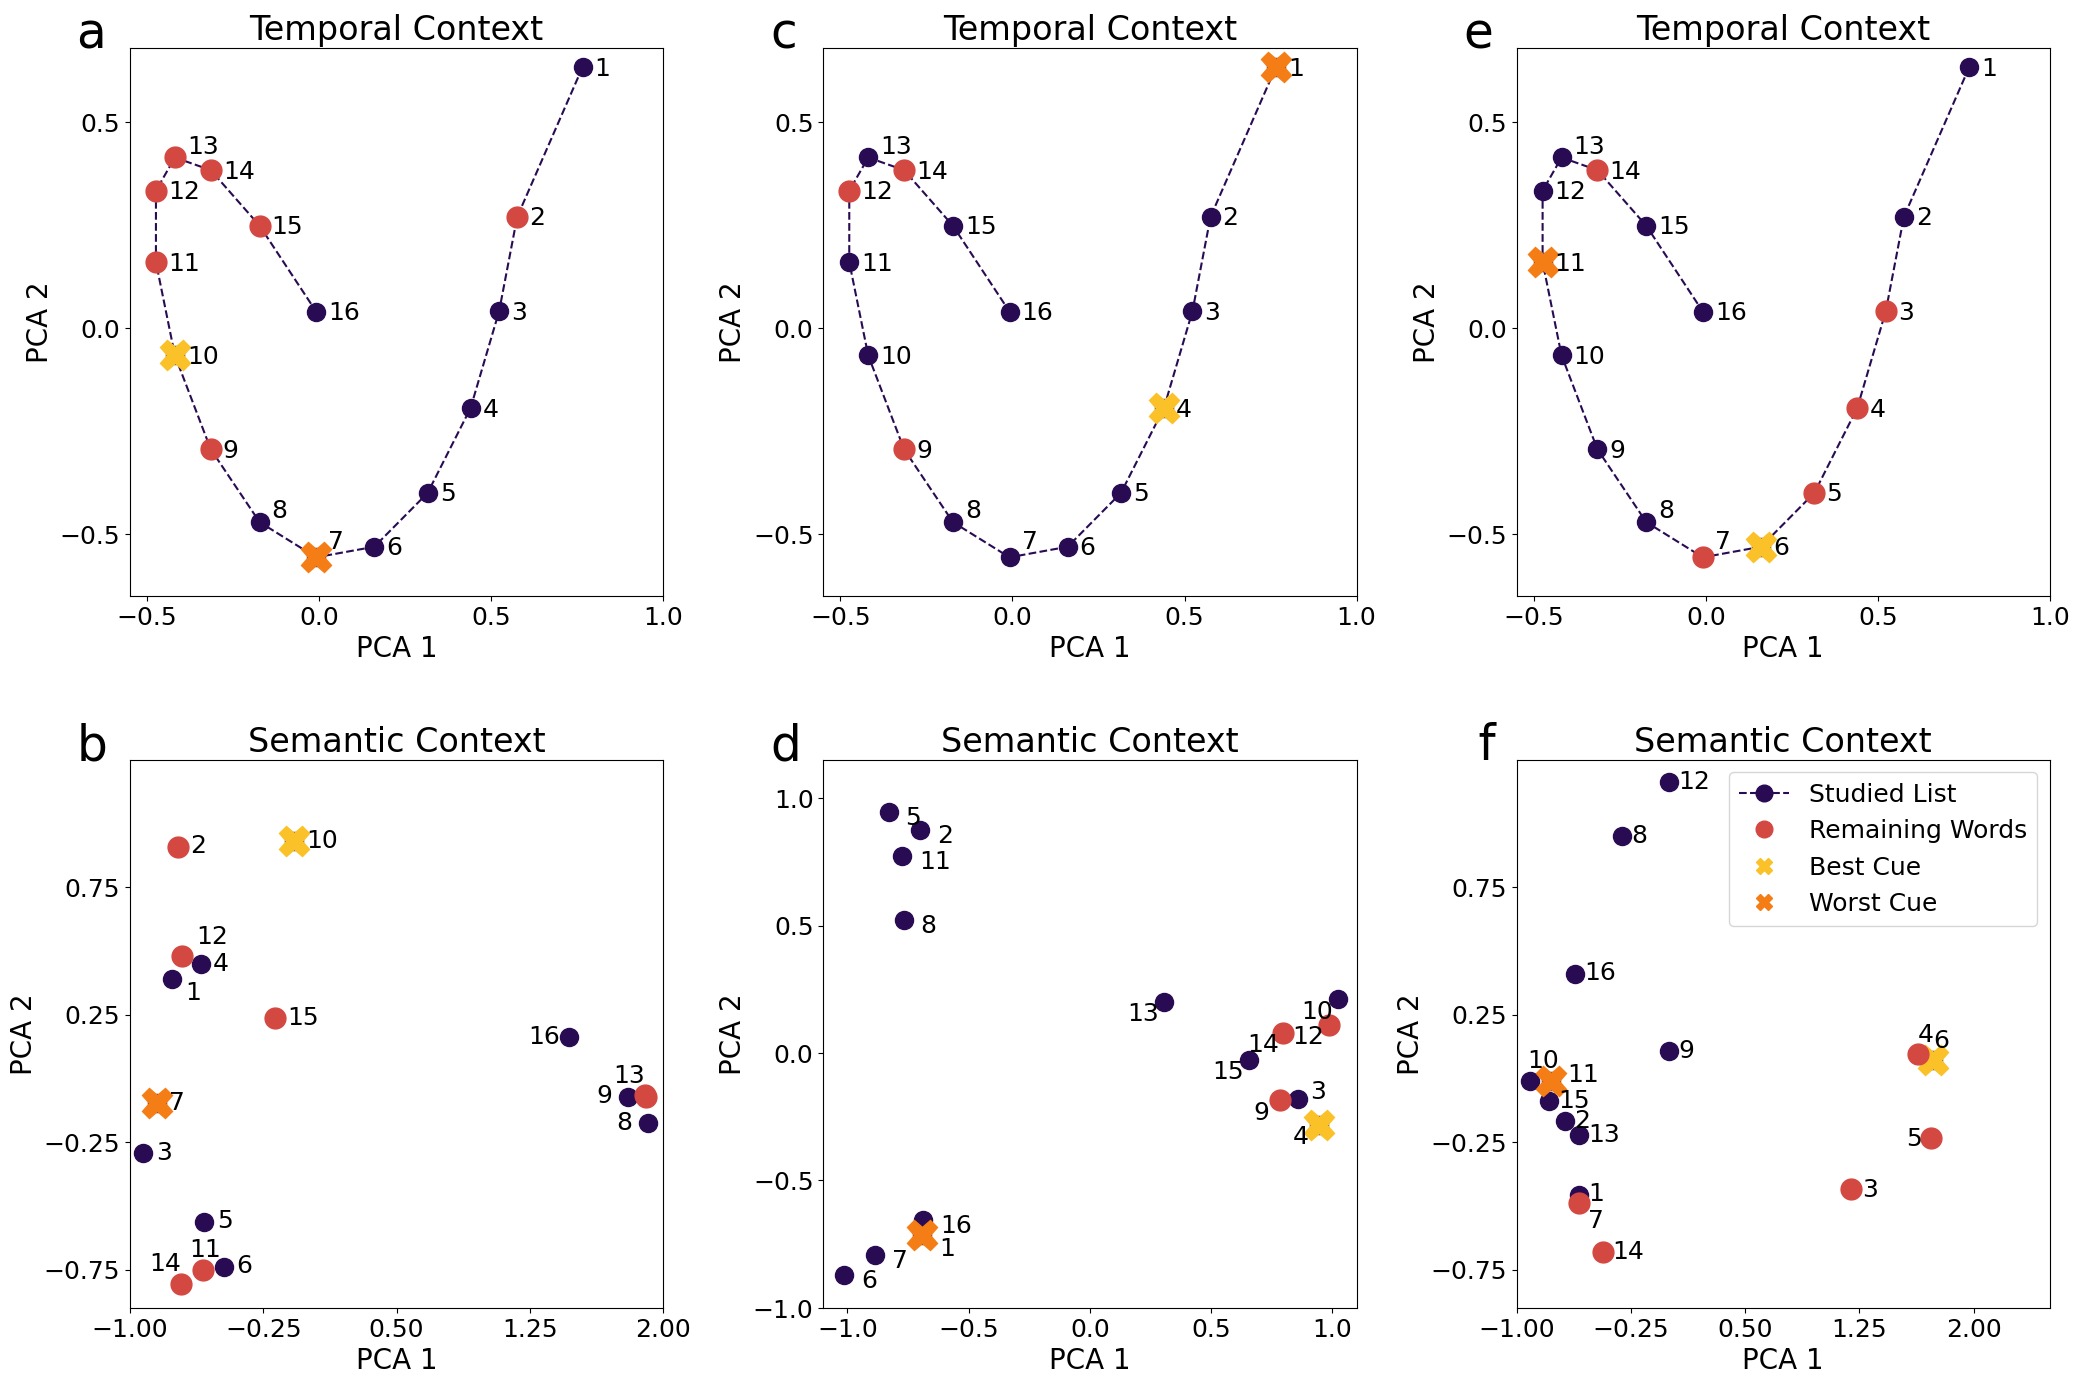

In [29]:
fig, axs = plt.subplots(figsize=(24,18), nrows=2,ncols=3); col=-1
plt.rcParams['font.size'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
for number in [88,165,49]: #which trials to print
    
    # setup
    col+=1
    #can remove ifs part of statement; only for recreating original figure rmdrs can switch
    if number==88: i_min = 1; i_max = 2
    elif number==165: i_min = 1; i_max = 2
    elif number==49: i_min = 4; i_max = 0
    else:
        acc = [np.mean(x) for x in accs[number]] # mean performanance for each reminder
        i_min = np.argmin(acc) # worst reminder
        i_max = np.argmax(acc) # best reminder
    cset2=[cset[1],cset[4],cset[6],cset[5]]

    # episodic
    axs[0,col].plot(pcas[number][:,0],pcas[number][:,1],'o--',ms=13,c=cset2[0])         # all words
    for i in range(len(pcas[number])): 
        if i==6: axs[0,col].text(pcas[number][i,0]+.035,pcas[number][i,1]+.02,str(i+1))
        elif i==7 or i==12: axs[0,col].text(pcas[number][i,0]+.035,pcas[number][i,1]+.01,str(i+1))
        else: axs[0,col].text(pcas[number][i,0]+.035,pcas[number][i,1]-.02,str(i+1))
    axs[0,col].plot(pcas[number][reminders[number][i_max],0],
                pcas[number][reminders[number][i_max],1],'X',ms=22,c=cset2[2])      # best reminder
    axs[0,col].plot(pcas[number][reminders[number][i_min],0],
                pcas[number][reminders[number][i_min],1],'X',ms=22,c=cset2[3])      # worst reminder
    for i in range(len(reminders[number])):                                         # remaining words
        if i!=i_max and i!=i_min: axs[0,col].plot(pcas[number][reminders[number][i],0],
                                              pcas[number][reminders[number][i],1],'o',ms=15,c=cset2[1])
    axs[0,col].set_title('Temporal Context'); 
    axs[0,col].set_xlabel('PCA 1',fontsize=20); axs[0,col].set_ylabel('PCA 2',fontsize=20)
    axs[0,col].axis([-.55,.88,-.65,.68])
    axs[0,col].set_xticks([x/100 for x in range(-50,101,50)])
    axs[0,col].set_yticks([x/100 for x in range(-50,51,50)])
    letter = 'a' if col==0 else ('c' if col==1 else 'e')
    axs[0,col].text(-0.1, 1, letter, transform=axs[0,col].transAxes, size=35)

    # semantic
    for i in range(len(pcas[number])):  #shift one point over for visibility
        if number==88 and i==8: axs[1,col].plot(pcas[number][i,2]-.1,pcas[number][i,3],'o',ms=13,c=cset2[0])
        else: axs[1,col].plot(pcas[number][i,2],pcas[number][i,3],'o',ms=13,c=cset2[0])           # all words
    
    # label by serial position (PCAs vary, so chuck of code for each plot)
    if number==88:
        for i in range(len(pcas[number])): 
            if i==0: axs[1,col].text(pcas[number][i,2]+.07,pcas[number][i,3]-.08,str(i+1))
            elif i==7: axs[1,col].text(pcas[number][i,2]-.18,pcas[number][i,3]-.025,str(i+1))
            elif i==8: axs[1,col].text(pcas[number][i,2]-.28,pcas[number][i,3]-.025,str(i+1))
            elif i==10: axs[1,col].text(pcas[number][i,2]-.08,pcas[number][i,3]+.05,str(i+1))
            elif i==11: axs[1,col].text(pcas[number][i,2]+.08,pcas[number][i,3]+.05,str(i+1))
            elif i==12 or i==13: axs[1,col].text(pcas[number][i,2]-.18,pcas[number][i,3]+.05,str(i+1))
            elif i==15: axs[1,col].text(pcas[number][i,2]-.23,pcas[number][i,3]-.025,str(i+1))
            else: axs[1,col].text(pcas[number][i,2]+.07,pcas[number][i,3]-.025,str(i+1))
            axs[1,col].axis([-1,2,-.9,1.25])
            axs[1,col].set_xticks([x/100 for x in range(-100,201,75)])
            axs[1,col].set_yticks([x/100 for x in range(-75,76,50)])
    
    elif number==165:
        for i in range(len(pcas[number])): 
            if i==0: axs[1,col].text(pcas[number][i,2]+.07,pcas[number][i,3]-.08,str(i+1))
            elif i==2: axs[1,col].text(pcas[number][i,2]+.05,pcas[number][i,3],str(i+1))
            elif i==3 or i==8: axs[1,col].text(pcas[number][i,2]-.11,pcas[number][i,3]-.075,str(i+1))
            elif i==9 or (i>=11 and i!=15): axs[1,col].text(pcas[number][i,2]-.15,pcas[number][i,3]-.075,str(i+1))
            else: axs[1,col].text(pcas[number][i,2]+.07,pcas[number][i,3]-.05,str(i+1))
            axs[1,col].axis([-1.1,1.1,-1,1.15])
            axs[1,col].set_xticks([x/100 for x in range(-100,101,50)])
            axs[1,col].set_yticks([x/100 for x in range(-100,101,50)])
            
    elif number==49:
        for i in range(len(pcas[number])): 
            if i==2: axs[1,col].text(pcas[number][i,2]+.07,pcas[number][i,3]-.03,str(i+1))
            elif i==3 or i==5: axs[1,col].text(pcas[number][i,2],pcas[number][i,3]+.05,str(i+1))
            elif i==4: axs[1,col].text(pcas[number][i,2]-.16,pcas[number][i,3]-.03,str(i+1))
            elif i==6: axs[1,col].text(pcas[number][i,2]+.06,pcas[number][i,3]-.1,str(i+1))
            elif i==9: axs[1,col].text(pcas[number][i,2]-.02,pcas[number][i,3]+.05,str(i+1))
            elif i==10: axs[1,col].text(pcas[number][i,2]+.11,pcas[number][i,3],str(i+1))
            else: axs[1,col].text(pcas[number][i,2]+.06,pcas[number][i,3]-.025,str(i+1))
            axs[1,col].axis([-1,2.5,-.9,1.25])
            axs[1,col].set_xticks([x/100 for x in range(-100,251,75)])
            axs[1,col].set_yticks([x/100 for x in range(-75,76,50)])
        
    axs[1,col].plot(pcas[number][reminders[number][i_max],2],
                pcas[number][reminders[number][i_max],3],'X',ms=22,c=cset2[2])      # best reminder
    axs[1,col].plot(pcas[number][reminders[number][i_min],2],
                pcas[number][reminders[number][i_min],3],'X',ms=22,c=cset2[3])      # worst reminder
    for i in range(len(reminders[number])):                                         # remaining words
        if i!=i_max and i!=i_min: axs[1,col].plot(pcas[number][reminders[number][i],2],
                                                  pcas[number][reminders[number][i],3],'o',ms=15,c=cset2[1])

    axs[1,col].set_title('Semantic Context'); 
    axs[1,col].set_xlabel('PCA 1'); axs[1,col].set_ylabel('PCA 2')
    letter = 'b' if col==0 else ('d' if col==1 else ' f')
    axs[1,col].text(-0.1, 1, letter, transform=axs[1,col].transAxes, size=35)

# details
leg = [ Line2D([0],[0],marker='o',ms=12,color=cset2[0],ls= '--', label='Studied List'),
        Line2D([0],[0],marker='o',ms=12,color=cset2[1],ls='None',label='Remaining Words'),
        Line2D([0],[0],marker='X',ms=12,color=cset2[2],ls='None',label='Best Cue'),
        Line2D([0],[0],marker='X',ms=12,color=cset2[3],ls='None',label='Worst Cue')]
axs[1,2].legend(handles=leg,loc="upper right",fontsize=18)
#print("Trial "+str(number)+" best avg:",round(np.max(acc),3),"\n       worse avg:",round(np.min(acc),3))
plt.subplots_adjust(0.1, 0.2, .9, 0.9, 0.3, 0.3)
plt.savefig("figs/CornellFig3.pdf", format="pdf", bbox_inches="tight")
plt.show()

### <p></p>

### <p></p>

### RESULTS

### Initial Recall Behavior (Figure 5, Appendix A)


 ----- PILOT DATA (PARAMETER SET FIT TO THESE PATTERNS) -----



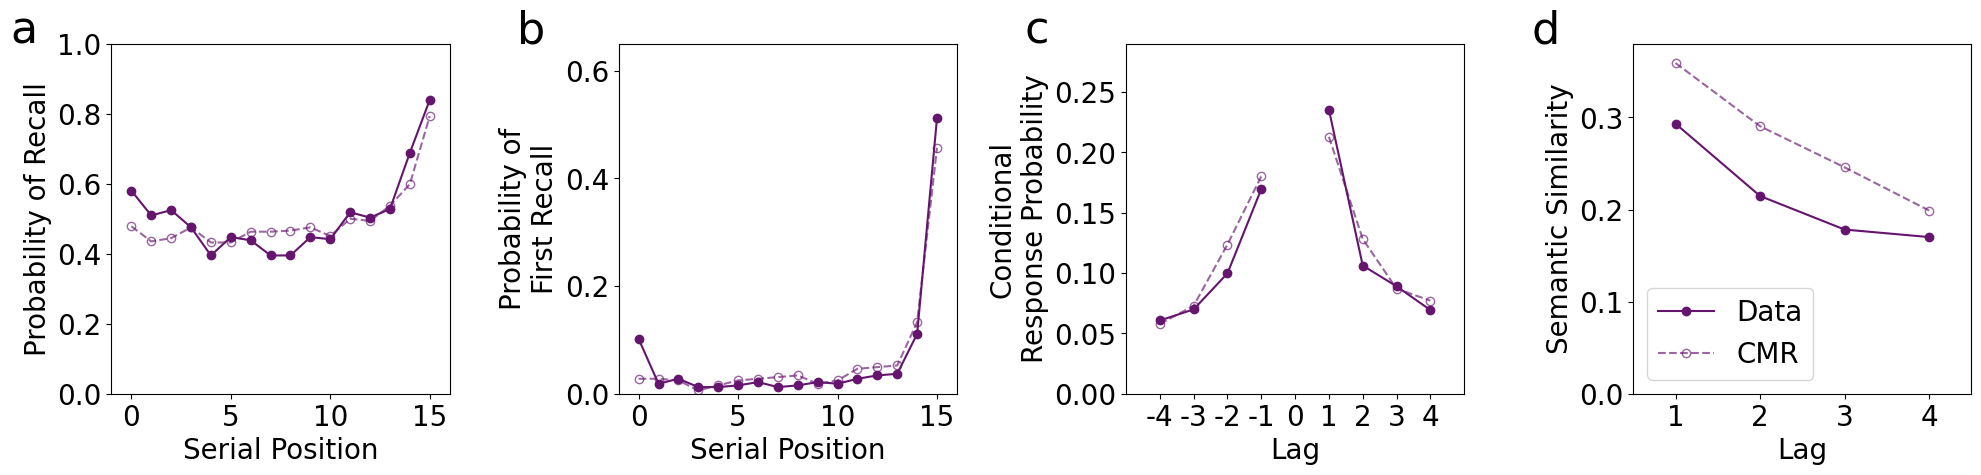


 ----- FINAL DATA (PARAMETER SET PRE-DETERMINED) -----



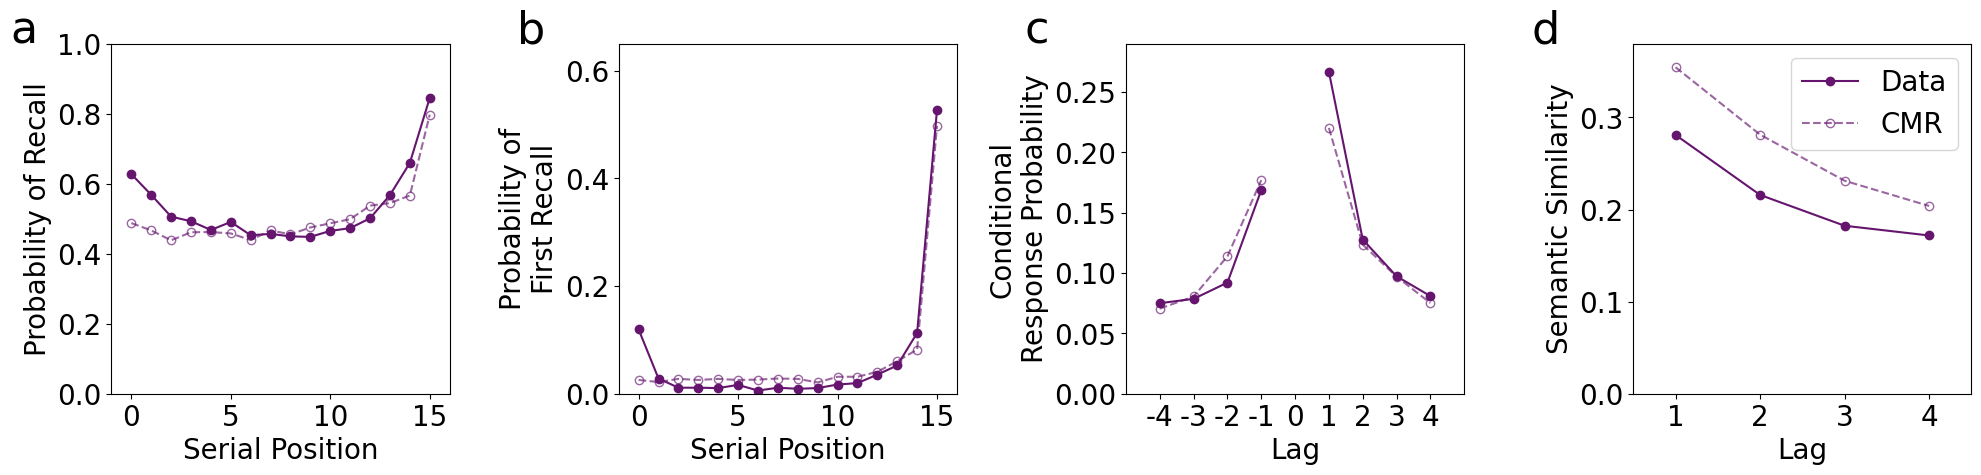

In [30]:
# import package
from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs
import fitCMR.script_fitCMRprob as fitCMR


# load model fitting results from fitCMR folder
pbounds = { 'beta_enc': (0.5,0.85),  # rate of context drift during encoding
            'beta_rec': (0.75,1.0),  # rate of context drift during recall
            'gamma_fc': (0,0.5),     # learning rate, feature-to-context
            'gamma_cf': (0,0.5),     # learning rate, context-to-feature
            's_cf': (0.75,1.5),      # scale of semantic associations
            'phi_s': (1.0,5.0),      # primacy parameter - scale
            'phi_d': (1.0,3.0),      # primacy parameter - decay
            'epsilon_d': (1,3),      # stopping probability - scale     
            'k': (4,8),              # luce choice rule
          }

# bounded region of parameter space
optimizer = BayesianOptimization(f=fitCMR.obj_func_prob, pbounds=pbounds, random_state=1)
load_logs(optimizer, logs=["fitCMR/log0822_pilotscued_v0_1.json"])

# best model parameters
params = optimizer.max['params']
param_dict = {
    'beta_enc': params['beta_enc'],    # rate of context drift during encoding
    'beta_rec': params['beta_rec'],    # rate of context drift during recall
    'beta_rec_post': 1,                # rate of context drift between lists (i.e., post-recall)
    'gamma_fc': params['gamma_fc'],'scale_fc': 1-params['gamma_fc'],    # learning rate, feature-to-context
    'gamma_cf': params['gamma_cf'],'scale_cf': 1-params['gamma_cf'],    # learning rate, context-to-feature
    's_cf': params['s_cf'],      # scales influence of semantic similarity on M_CF matrix
    's_fc': 0.0,                 # scales influence of semantic similarity on M_FC matrix
    'phi_s': params['phi_s'],    # primacy parameter
    'phi_d': params['phi_d'],    # primacy parameter
    'epsilon_s': 0.0,            # baseline activiation for stopping probability 
    'epsilon_d': params['epsilon_d'], # scale parameter for stopping probability 
    'k': params['k'],            # scale parameter in luce choice rule during recall
    'primacy': 0.0,              # specific to optimal CMR
    'enc_rate': 1.0,             # specific to optimal CMR
}

# plot
from analysis_helpers import get_curves
print("\n ----- PILOT DATA (PARAMETER SET FIT TO THESE PATTERNS) -----\n")
data_path = 'data/pilotdata/pres.txt'
data_rec_path = 'data/pilotdata/recs.txt'
subjects_path = 'data/pilotdata/subject_id.txt'
get_curves(data_path, data_rec_path, subjects_path, param_dict, ll, lag_examine=4, name='A1')

print("\n ----- FINAL DATA (PARAMETER SET PRE-DETERMINED) -----\n")
data_path = 'data/finaldata_opt/pres.txt'
data_rec_path = 'data/finaldata_opt/recs.txt'
subjects_path = 'data/finaldata_opt/subject_id.txt'
get_curves(data_path, data_rec_path, subjects_path, param_dict, ll, lag_examine=4, name='5')

### <p></p>

### <p></p>

### Post-cue Recall Behavior (Figure 6)

In [31]:
from scipy import stats
print(" * [CMRA] M=%.2f, SD=%.2f"%(np.mean(post_amts_CMRA),np.std(post_amts_CMRA)))
print(" * [DATA] M=%.2f, SD=%.2f"%(np.mean(post_amts_data),np.std(post_amts_data)))

# test data recall gain
x = recs_amts_data; y = [recs_amts_data[i] + post_amts_data[i] for i in range(ntrials)]
stat, p = ttest_rel(x, y, alternative='less'); df = len(x)-1
ci_x = stats.t.interval(confidence=0.95, df=df, loc=np.mean(x), scale=stats.sem(x)) 
ci_y = stats.t.interval(confidence=0.95, df=df, loc=np.mean(y), scale=stats.sem(y)) 

# effect size and its CI
u1 = np.mean(x); n1 = len(x); s1 = np.std(x)
u2 = np.mean(y); n2 = len(y); s2 = np.std(y)
d = (u1 - u2) / (np.sqrt( ((n1-1) * s1**2 + (n2-1) * s2**2 ) / (n1+n2-2)))
std_d = np.sqrt( ((n1+n2)/(n1*n2)) + ((d**2)/(2*(n1+n2))) )
low_ci_d = d-1.96*std_d; upp_ci_d = d+1.96*std_d

# print results
print(" * [DATA] Recall before a reminder (M=%.2f, CI=[%.2f,%.2f])"%(np.mean(recs_amts_data),ci_x[0],ci_x[1])+
          " vs. recall after a reminder (M=%.2f, CI=[%.2f,%.2f])"%(
              np.mean(post_amts_data+np.mean(recs_amts_data)),ci_y[0],ci_y[1])+
          "\n     t(%.0f)=%.2f, p=%.3f, d=%.2f, 95CI=[%.2f,%.2f]"%(df,stat,p,d,low_ci_d,upp_ci_d))

 * [CMRA] M=1.58, SD=1.21
 * [DATA] M=0.80, SD=1.13
 * [DATA] Recall before a reminder (M=8.47, CI=[8.33,8.62]) vs. recall after a reminder (M=9.27, CI=[9.12,9.41])
     t(1523)=-27.50, p=0.000, d=-0.27, 95CI=[-0.35,-0.20]


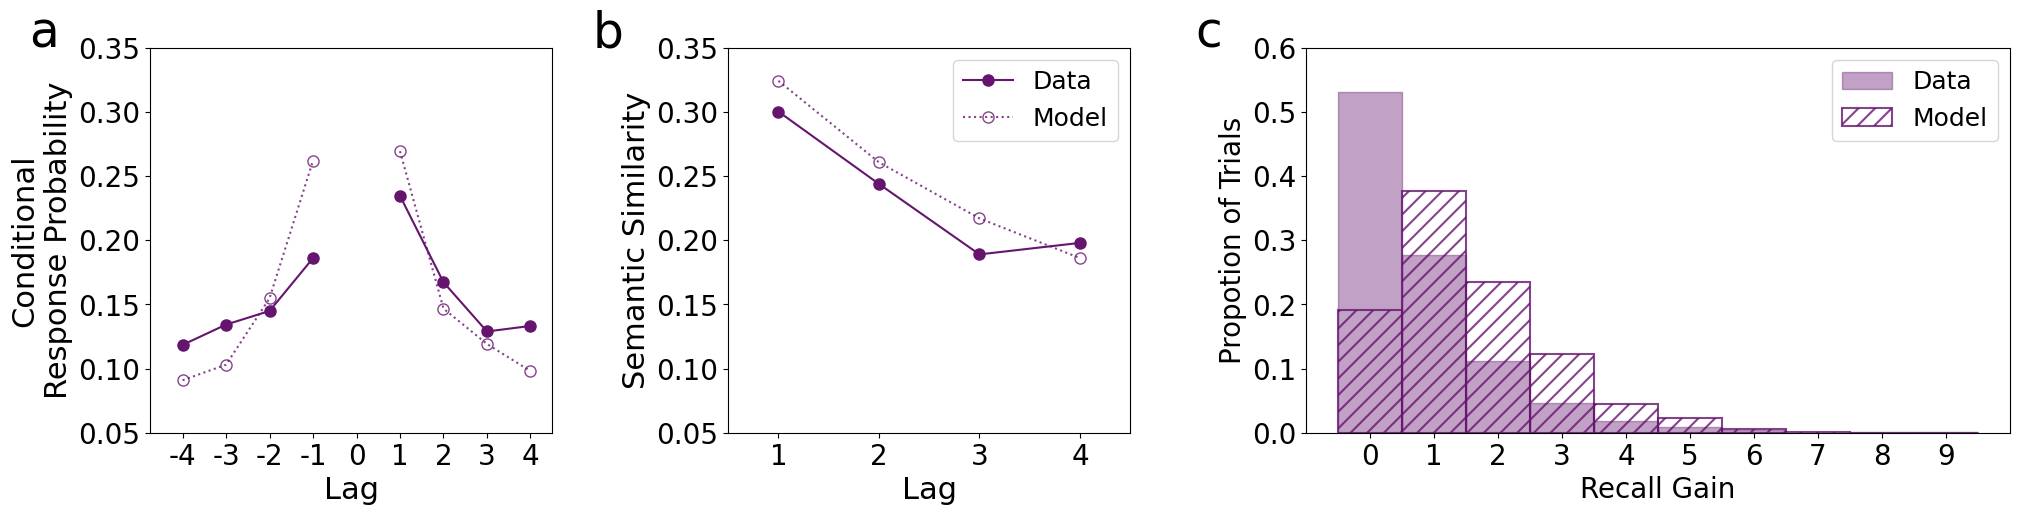

In [32]:
from analysis_helpers import post_cue_plots #see analysis_helpers.py for description of this function

# obtain files from human data for analyzing recall behavior
LSA_mat = np.loadtxt(exp+'GloVe.txt', delimiter=',', dtype=np.float32)
pres_remaining = np.loadtxt(exp+'/pres_remaining.txt', delimiter=',')
recs_data = np.loadtxt(exp+'/post_rmdr_fromcue.txt', delimiter=',')
data_recs_fromcue = np.loadtxt(exp+'/post_rmdr_fromcue.txt', delimiter=',')

# obtain list of CMR's recalls to compare
pres = np.loadtxt(exp+'/pres.txt', delimiter=',')
cmr_recs_fromcue = []
for i in range(len(recalls)):                 # for every possible cue,
    CMRs_sp = int(rmdr_idxs_CMR[i])           # get cue
    pres_sp = [int(reminders[i][CMRs_sp])]    # get cue position in list
    recs_fromcue = [int(pres[i][pres_sp])]    # start list with cue serial position
    for r in recalls[i][CMRs_sp]: recs_fromcue.append(int(pres[i][r]))  # append post-cue recall serial positions
    for z in range(ll-len(recs_fromcue)): recs_fromcue.append(0)        # buffer with 0s
    cmr_recs_fromcue.append(recs_fromcue)     # append trial to overall list
    
# get frequency distribution of post cue recall amount
post_dist_data = []; post_dist_CMRA = []
for i in range(0,int(np.max(post_amts_data))+1):
    cnt_data = 0; cnt_CMRA = 0
    for j in range(len(post_amts_data)):
        if post_amts_data[j] == i: cnt_data += 1
        if (post_amts_CMRA[j] < i+.5) and (post_amts_CMRA[j] >= i-.5): cnt_CMRA += 1
    post_dist_data.append(cnt_data/len(post_amts_data))
    post_dist_CMRA.append(cnt_CMRA/len(post_amts_CMRA))

# CRP and semantic similarity for post-cue recall session
# as well as frequency distribution of recall amount
_,_,_ = post_cue_plots([pres_remaining, pres_remaining],[recs_data, cmr_recs_fromcue], 
                       LSA_mat, lag_examine=4, lls=['vary','vary'], when='Post', plot=True,
                      post_dist_data=post_dist_data, post_dist_CMRA=post_dist_CMRA)

### <p></p>

### <p></p>

### Effectiveness of Model-Based Cue Selection (Figure 7)

In [33]:
print("\n\033[1m Log-transformed association of Data's recall gain with CMR's average recall gain: \033[0m")
# note this value can change between simulations, but is similar and significance is always the same

# log transform
nRemaining = [16-i for i in recs_amts_data]
nRemaining_log = [math.log(x+0.00001) for x in nRemaining]
recs_amts_data_log = [math.log(x+0.00001) for x in recs_amts_data]
post_amts_data_log = [math.log(x+0.00001) for x in post_amts_data]
post_amts_CMRA_log = [math.log(x+0.00001) for x in post_amts_CMRA]

x = post_amts_data_log
y = post_amts_CMRA_log
covar = nRemaining_log
data = {'covar':covar, 'x':x, 'y':y}; df = pd.DataFrame(data)
stats = pg.partial_corr(data=df, x='x', y='y', covar='covar', method='spearman').round(3)
df = stats['n'][0]-1-len([*set(covar)]); r = stats['r'][0]; p = stats['p-val'][0]
print(" * Partial correlation, controlling for # of words remaining: \n       rho("+str(df)+")="+str(r)
     +", 95%CI=["+str(stats['CI95%'][0][0])+","+str(stats['CI95%'][0][1])+"], p="+str(p))


 Log-transformed association of Data's recall gain with CMR's average recall gain: 
 * Partial correlation, controlling for # of words remaining: 
       rho(1508)=0.149, 95%CI=[0.1,0.2], p=0.0


In [34]:
# best/worst condition analysis imports (see analysis_helpers for descriptions of functions)
from analysis_helpers import perf_by_type, permutation_test, plot_rmdr_types, get_cosine_similarity, plot_cueconds

def bw_analysis(pids, data, log):
    hum_low, hum_rnd, hum_upp, _ = perf_by_type(data, nsubjects, ntrials_persub, exp, pids, log)
    
    if log: 
        p = permutation_test([hum_low, hum_rnd, hum_upp], "DATA log-transformed", test='increasing'); print("")
    else:
        data = [hum_low, hum_rnd, hum_upp]; types = ['WORST','RAND ','BEST ']
        for stat in range(3):
            u = np.mean(data[stat]); sd = np.std(data[stat]); df = len(hum_low)-1
            ci= stats.t.interval(confidence=0.95, df=df, loc=u, scale=stats.sem(data[stat]))
            print(" * "+types[stat]+": M = %.2f, SD = %.2f, 95CI=[%.2f, %.2f]"%(u,sd, ci[0],ci[1]))
        
    return hum_low, hum_rnd, hum_upp

 * WORST: M = 0.73, SD = 0.67, 95CI=[0.62, 0.84]
 * RAND : M = 0.74, SD = 0.75, 95CI=[0.61, 0.86]
 * BEST : M = 0.86, SD = 0.68, 95CI=[0.75, 0.97]
 * Permutation test for DATA log-transformed has p = 0.0

 * Worst vs Best: t(140)=-3.38, p=0.001, d=-0.34, 95CI=[-0.57,-0.10]


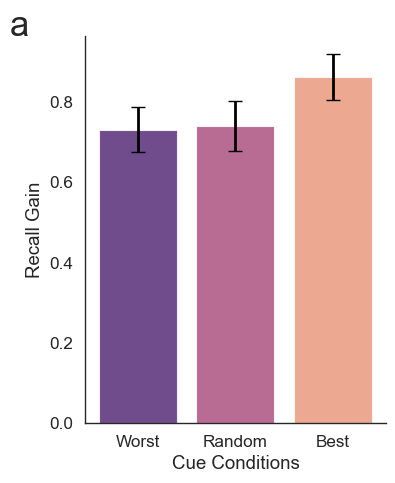

In [35]:
#################
### FIGURE 7A ###
#################
from scipy import stats
hum_low, hum_rnd, hum_upp = bw_analysis(list(range(nsubjects)), post_amts_data, log=False) #get descriptives
data = [hum_low, hum_rnd, hum_upp]
hum_low, hum_rnd, hum_upp = bw_analysis(list(range(nsubjects)), post_amts_data_log, log=True) #get perm test
data_log = [hum_low, hum_rnd, hum_upp]

# sample and ttest
x=data_log[0]; y=data_log[2]
t,p=ttest_rel(x,y); sig = "***" if p<.001 else ("**" if p<.01 else ("*" if p<.05 else " ns "))

# effect size and its CI
u1 = np.mean(x); n1 = len(x); s1 = np.std(x)
u2 = np.mean(y); n2 = len(y); s2 = np.std(y)
d = (u1 - u2) / (np.sqrt( ((n1 - 1) * s1**2 + (n2 - 1) * s2**2 ) / (n1 + n2 - 2)))
std_d = np.sqrt( ((n1+n2)/(n1*n2)) + ((d**2)/(2*(n1+n2))) )
low_ci_d = d-1.96*std_d; upp_ci_d = d+1.96*std_d

# output
print(" * Worst vs Best: t("+str(len(x)-1)+")=%.2f, p=%.3f, d=%.2f, 95CI=[%.2f,%.2f]"%(t,p,d,low_ci_d,upp_ci_d))

#plot nontransformed values
plot_rmdr_types(data)

 * WORST: M = 0.10, 95CI=[0.09, 0.11]
 * RAND : M = 0.14, SD=0.04
 * BEST : M = 0.16, 95CI=[0.15, 0.16]
 * Permutation test for context similarity has p = 0.0
 * Worst vs Best: t(140)=-11.55, p=0.000, d=-1.12, 95CI=[-1.37,-0.87]


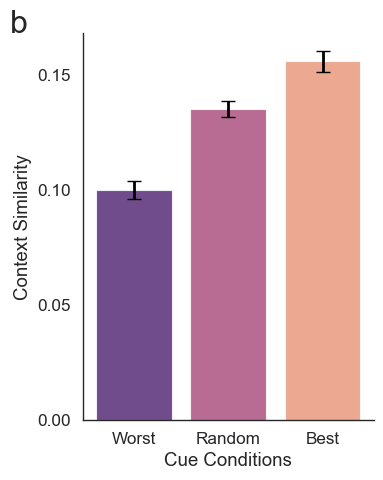

In [36]:
#################
### FIGURE 7B ###
#################

worst_cdiff, rand_cdiff, best_cdiff = get_cosine_similarity(
    net_cs, CMR_sp, reminders, rmdr_idxs_CMR, ntrials, nsubjects, ntrials_persub, exp)

data = [worst_cdiff, rand_cdiff, best_cdiff]; types = ['WORST','RAND ','BEST ']
for stat in range(3):
    if stat != 1:
        u = np.mean(data[stat])
        ci= stats.t.interval(confidence=0.95, df=df, loc=u, scale=stats.sem(data[stat]))
        print(" * "+types[stat]+": M = %.2f, 95CI=[%.2f, %.2f]"%(u,ci[0],ci[1]))
    else: print(" * "+types[stat]+": M = %.2f, SD=%.2f"%(np.mean(data[stat]),np.std(data[stat])))  

permutation_test(data, name='context similarity',test='increasing')
plot_cueconds(data, ylabel="Context Similarity",ystep=.05,ymax=0.25,ytext=.225,letter='b')

 * Categories recall before a cue (M=3.49, CI=[3.42,3.56])vs. recalled after a cue ((M=3.64, CI=[3.57,3.71])
     t(171)=-11.43, p=0.000, d=-0.32, 95CI=[-0.53,-0.10]
 * Such that an additional 0.15 cats. were recalled on average (SD=0.17) 

Number of categories gain by cue condition (ordered worst, random, best):
 * M = 0.12, 95CI=[0.09, 0.16]
 * M = 0.16, SD=0.24
 * M = 0.21, 95CI=[0.17, 0.25]
 * Permutation test for category gain has p = 0.0
 * Worst vs Best: t(140)=-3.61, p=0.000, d=-0.40, 95CI=[-0.63,-0.16]


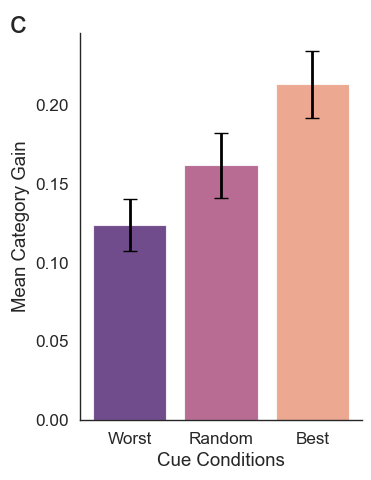

In [37]:
#################
### FIGURE 7C ###
#################

# load data files
pres_cats = np.loadtxt(exp+"pres_cats.txt",delimiter=',')
recs_cats = np.loadtxt(exp+'recs_cats.txt',delimiter=',')
post_rmdr_cats = np.loadtxt(exp+'/post_rmdr_cats.txt',delimiter=',')
rmdr_all = np.loadtxt(exp+'/rmdr_all.txt',delimiter=',')
time_all = np.loadtxt(exp+'/cue_times_all.txt',delimiter=',')
with open(exp+'/rmdr_types.txt', 'r') as file: rmdr_types = file.readlines()

# STEP 1: look at how often categories were recalled BEFORE a cue
all_cats = [[*set(pres)] for pres in pres_cats]
cats_recalled = [[int(c) for c in [*set(recs)] if c>0] for recs in recs_cats]

# STEP 2: look at how often categories were recalled AFTER a cue
recs_total_cats = []
for trial in range(ntrials):
    cats = [int(c) for c in recs_cats[trial] if c>0] #precue cats
    for x in [int(c) for c in post_rmdr_cats[trial] if c>0]: cats.append(x) #postcue cats added
    recs_total_cats.append(cats)
cats_total_recalled = [[int(c) for c in [*set(rec)] if c>0] for rec in recs_total_cats]

# STEP 3: group by subject for analysis:
with open(exp+'/rmdr_types_all.txt', 'r') as file: rmdr_types_all = file.readlines()
ncats_recalled_bySub=[]; ncats_recalled_byCondbySub=[[] for x in range(3)]; cued_cnt = 0
ncats_total_recalled_bySub=[]; ncats_total_recalled_byCondbySub=[[] for x in range(3)]
for subject in range(nsubjects):
    ncats = []; ncats_byCond = [[] for x in range(3)]
    ncats_total = []; ncats_total_byCond = [[] for x in range(3)]
    for trial in range(ntrials_persub):
        idx = subject*ntrials_persub+trial
        r = rmdr_types_all[idx]
        if rmdr_all[idx]>=0 and time_all[idx]>=10000: 
            ncats.append(len(cats_recalled[cued_cnt]))
            ncats_total.append(len(cats_total_recalled[cued_cnt]))
            i=0 if r=='worst\n' else (1 if r=='random\n' else (2 if r=='best\n' else 3))
            ncats_byCond[i].append(len(cats_recalled[cued_cnt]))
            ncats_total_byCond[i].append(len(cats_total_recalled[cued_cnt]))
            cued_cnt+=1
    if len(ncats)>0: ncats_recalled_bySub.append(np.mean(ncats))
    if len(ncats_total)>0: ncats_total_recalled_bySub.append(np.mean(ncats_total))
    if len(ncats_byCond[0])>0 and len(ncats_byCond[1])>0 and len(ncats_byCond[2])>0:
        for i in range(3): ncats_recalled_byCondbySub[i].append(np.mean(ncats_byCond[i]))
    if len(ncats_total_byCond[0])>0 and len(ncats_total_byCond[1])>0 and len(ncats_total_byCond[2])>0:
        for i in range(3): ncats_total_recalled_byCondbySub[i].append(np.mean(ncats_total_byCond[i]))
            
            
# STEP 4: examine category gain within subjects
# samples and ttest
x = ncats_recalled_bySub; y = ncats_total_recalled_bySub
stat, p = ttest_rel(x, y, alternative='less'); df = len(x)-1
ci_x = stats.t.interval(confidence=0.95, df=df, loc=np.mean(x), scale=stats.sem(x)) 
ci_y = stats.t.interval(confidence=0.95, df=df, loc=np.mean(y), scale=stats.sem(y)) 
# effect size and its CI
u1 = np.mean(x); n1 = len(x); s1 = np.std(x)
u2 = np.mean(y); n2 = len(y); s2 = np.std(y)
d = (u1 - u2) / (np.sqrt( ((n1 - 1) * s1**2 + (n2 - 1) * s2**2 ) / (n1 + n2 - 2)))
std_d = np.sqrt( ((n1+n2)/(n1*n2)) + ((d**2)/(2*(n1+n2))) )
low_ci_d = d-1.96*std_d; upp_ci_d = d+1.96*std_d
# print
print(" * Categories recall before a cue (M=%.2f, CI=[%.2f,%.2f])"%(np.mean(x),ci_x[0],ci_x[1])+
      
      "vs. recalled after a cue ((M=%.2f, CI=[%.2f,%.2f])"%(np.mean(y),ci_y[0],ci_y[1])+
      "\n     t(%.0f)=%.2f, p=%.3f, d=%.2f, 95CI=[%.2f,%.2f]"%(df,stat,p,d,low_ci_d,upp_ci_d))
print(" * Such that an additional %.2f cats. were recalled on average (SD=%.2f)"%
      (np.mean([y[i]-x[i] for i in range(len(x))]),np.std([y[i]-x[i] for i in range(len(x))])),"\n")


# STEP 5: look at descriptives by cue condition
print("Number of categories gain by cue condition (ordered worst, random, best):")
ncats_gain_recalled_byCondbySub = [[] for j in range(3)]
for j in range(3):
    ncats_gain_recalled_byCondbySub[j] = [ncats_total_recalled_byCondbySub[j][i]-ncats_recalled_byCondbySub[j][i] 
                                           for i in range(len(ncats_total_recalled_byCondbySub[j]))]
    
    if j != 1:
        u = np.mean(ncats_gain_recalled_byCondbySub[j])
        ci= stats.t.interval(confidence=0.95, df=df, loc=np.mean(ncats_gain_recalled_byCondbySub[j]), scale=stats.sem(ncats_gain_recalled_byCondbySub[j]))
        print(" * M = %.2f, 95CI=[%.2f, %.2f]"%(u,ci[0],ci[1]))
    else: 
        print(" * M = %.2f, SD=%.2f"%(np.mean(ncats_gain_recalled_byCondbySub[j]),np.std(ncats_gain_recalled_byCondbySub[j])))  
        
# STEP 6: test and plot
permutation_test(ncats_gain_recalled_byCondbySub, name='category gain',test='increasing')
plot_cueconds(data=ncats_gain_recalled_byCondbySub, ylabel='Mean Category Gain',
              ystep=.05, ymax=.30, ytext=.25, letter='c')

### <p></p>

### <p></p>

### Cue Selection Heuristics (Appendix B)

In [38]:
# first, prep the categorical information for analysis
plt.rcParams['figure.figsize']=(2,4)
pres = np.loadtxt(exp+'/pres.txt',delimiter=',')
pres_cats = np.loadtxt(exp+'/pres_cats.txt',delimiter=',')
recs_cats = np.loadtxt(exp+'/recs_cats.txt',delimiter=',')
rmdr_all = np.loadtxt(exp+'/rmdr_all.txt',delimiter=',')
time_all = np.loadtxt(exp+'/cue_times_all.txt',delimiter=',')
with open(exp+'/rmdr_types.txt', 'r') as file: rmdr_types = file.readlines()
pres_rem = np.loadtxt(exp+'/pres_remaining.txt',delimiter=',')

# 1) get presented categories
all_cats = [[*set(pres)] for pres in pres_cats]

# 2) get recalled categories
cats_recalled = [[int(c) for c in [*set(recs)] if c>0] for recs in recs_cats]
ncats_recalled = [len(trial) for trial in cats_recalled] #number of categories recalled on each trial

# 3) get number of items recalled per category
nitems_percat_each = []
for trial in range(ntrials):
    cats = [*set(pres_cats[trial])]; cnts = [0,0,0,0]
    for rec in recs_cats[trial]: 
        if rec>0: cnts[cats.index(rec)]+=1
    nitems_percat_each.append(cnts)

# 4) get unrecalled categories
cats_missed = [[cat for cat in all_cats[trial] if cat not in cats_recalled[trial]] for trial in range(ntrials)]

# 5) get category of shown reminder
pres_rem_cats = [[int(pres_cats[t][np.where(pres[t]==word)[0][0]])
                  for word in pres_rem[t] if word>0] for t in range(ntrials)]
rmdr_cats = [pres_rem_cats[trial][int(rmdr_idxs_data[trial])] for trial in range(ntrials)]

# 6) get remaining items by serial position
pres_rem_bySP = [[np.where(pres[t]==item)[0][0] for item in pres_rem[t] if item>0] for t in range(ntrials)]

In [39]:
def heursitic_ttest(x,y):
    t,p=ttest_rel(x,y); sig = "***" if p<.001 else ("**" if p<.01 else ("*" if p<.05 else " ns "))
    u1 = np.mean(x); n1 = len(x); s1 = np.std(x)
    u2 = np.mean(y); n2 = len(y); s2 = np.std(y)
    d = (u1 - u2) / (np.sqrt( ((n1 - 1) * s1**2 + (n2 - 1) * s2**2 ) / (n1 + n2 - 2)))
    std_d = np.sqrt( ((n1+n2)/(n1*n2)) + ((d**2)/(2*(n1+n2))) )
    low_ci_d = d-1.96*std_d; upp_ci_d = d+1.96*std_d
    print("   -  Proportion BEST  cues considered effective M=%.2f, SD=%.2f"%(u1,s1))
    print("   -  Proportion WORST cues considered effective M=%.2f, SD=%.2f"%(u2,s2))
    print("   -  t("+str(len(x)-1)+")=%.2f, p=%.3f, d=%.2f, 95CI=[%.2f,%.2f]"%(t,p,d,low_ci_d,upp_ci_d),"\n\n")

### <p></p>

In [40]:
print('\n SEMANTIC 0: On trials with an unaccessed category: let a "good" cue be within that category, '+
      '\n and a "bad" cue be in an already-accessed category.')

# sort shown cues by heuristic's definition of effectiveness by subject
best_cnts_bySub=[]; worst_cnts_bySub=[]; cued_cnt=0
for subject in range(nsubjects):
    best_cues = [0,0]; worst_cues = [0,0] #effective cnt vs ineffective cnt
    for trial in range(ntrials_persub):
        i = subject*ntrials_persub+trial
        if rmdr_all[i]>=0 and time_all[i]>=10000: #if a valid cue trial,
            if len(cats_missed[cued_cnt])>0: #if a trial to which this heuristic can be applied
                if rmdr_cats[cued_cnt] in cats_missed[cued_cnt]: #effective
                    if rmdr_types[cued_cnt] =='worst\n': worst_cues[0]+=1
                    elif rmdr_types[cued_cnt]=='best\n': best_cues[0]+=1
                else:  #ineffective
                    if rmdr_types[cued_cnt] =='worst\n': worst_cues[1]+=1
                    elif rmdr_types[cued_cnt]=='best\n': best_cues[1]+=1
            cued_cnt+=1
    if (best_cues[0]!=0 or best_cues[1]!=0) and (worst_cues[0]!=0 or worst_cues[1]!=0):
        best_cnts_bySub.append(best_cues[0]/(best_cues[0]+best_cues[1]))
        worst_cnts_bySub.append(worst_cues[0]/(worst_cues[0]+worst_cues[1]))

heursitic_ttest(x=best_cnts_bySub, y=worst_cnts_bySub)


 SEMANTIC 0: On trials with an unaccessed category: let a "good" cue be within that category, 
 and a "bad" cue be in an already-accessed category.
   -  Proportion BEST  cues considered effective M=0.73, SD=0.32
   -  Proportion WORST cues considered effective M=0.25, SD=0.37
   -  t(86)=9.00, p=0.000, d=1.38, 95CI=[1.05,1.71] 




In [41]:
print('\n SEMNATIC 1: Let a "good" cue be in a category with the most remaining items,'+
      '\n and a "bad" cue be in any other category.')

# sort shown cues by heuristic's definition of effectiveness by subject
best_cnts_bySub=[]; worst_cnts_bySub=[]; cued_cnt=0
for subject in range(nsubjects):
    best_cues = [0,0]; worst_cues = [0,0] #effective cnt vs ineffective cnt
    for trial in range(ntrials_persub):
        i = subject*ntrials_persub+trial
        idx = np.where(np.array(all_cats[cued_cnt])==rmdr_cats[cued_cnt])[0][0]
        if rmdr_all[i]>=0 and time_all[i]>=10000: #if a valid cue trial,
            if min(nitems_percat_each[cued_cnt])==nitems_percat_each[cued_cnt][idx]: #effective
                if rmdr_types[cued_cnt] =='worst\n': worst_cues[0]+=1
                elif rmdr_types[cued_cnt]=='best\n': best_cues[0]+=1
            else:  #ineffective
                if rmdr_types[cued_cnt] =='worst\n': worst_cues[1]+=1
                elif rmdr_types[cued_cnt]=='best\n': best_cues[1]+=1
            cued_cnt+=1
    if (best_cues[0]!=0 or best_cues[1]!=0) and (worst_cues[0]!=0 or worst_cues[1]!=0):
        best_cnts_bySub.append(best_cues[0]/(best_cues[0]+best_cues[1]))
        worst_cnts_bySub.append(worst_cues[0]/(worst_cues[0]+worst_cues[1]))

heursitic_ttest(x=best_cnts_bySub, y=worst_cnts_bySub)


 SEMNATIC 1: Let a "good" cue be in a category with the most remaining items,
 and a "bad" cue be in any other category.
   -  Proportion BEST  cues considered effective M=0.76, SD=0.24
   -  Proportion WORST cues considered effective M=0.42, SD=0.30
   -  t(148)=11.95, p=0.000, d=1.25, 95CI=[1.00,1.50] 




In [42]:
# for each temporal heuristic N
for n in range(2,5):
    
    # STEP 1: find temporal clusters
    tem_first_sp = []; idx=0; cnt=0
    for trial in pres_rem_bySP:
        tem_first_sp_i=[]
        for i in range(16):
            if n==2: 
                if i in trial and i+1 in trial: 
                    tem_first_sp_i.append(i); tem_first_sp_i.append(i+1)
            if n==3: 
                if i in trial and i+1 in trial and i+2 in trial: 
                    tem_first_sp_i.append(i); tem_first_sp_i.append(i+1); tem_first_sp_i.append(i+2)
            if n==4: 
                if i in trial and i+1 in trial and i+2 in trial and i+3 in trial: 
                    tem_first_sp_i.append(i); tem_first_sp_i.append(i+1); tem_first_sp_i.append(i+2)
                    tem_first_sp_i.append(i+3)
            if n==5: 
                if i in trial and i+1 in trial and i+2 in trial and i+3 in trial and i+4 in trial: 
                    tem_first_sp_i.append(i); tem_first_sp_i.append(i+1); tem_first_sp_i.append(i+2)
                    tem_first_sp_i.append(i+3);  tem_first_sp_i.append(i+4)
        tem_first_sp.append([*set(tem_first_sp_i)]); idx+=1
        if len(tem_first_sp_i)>0: cnt+=1
    print("\n TEMPORAL HEURISTIC: "+str(n)+" consecutive remaining items (%.2f of trials)"%(cnt/ntrials))
            
    # sort shown cues by heuristic's definition of effectiveness by subject
    best_cnts_bySub=[]; worst_cnts_bySub=[]; cued_cnt=0
    for subject in range(nsubjects):
        best_cues = [0,0]; worst_cues = [0,0] #effective cnt vs ineffective cnt
        for trial in range(ntrials_persub):
            i = subject*ntrials_persub+trial
            if rmdr_all[i]>=0 and time_all[i]>=10000: #if a valid cue trial,
                
                # first determine cue classification
                hit='ineffective' #start by assuming cue is ineffective
                if len(tem_first_sp[cued_cnt])>1:
                    for c in tem_first_sp[cued_cnt]: #for every cue in the cluster,
                        if c == pres_rem_bySP[cued_cnt][int(rmdr_idxs_data[cued_cnt])]:  #check if reminder match
                            hit='effective' #if it is cluster, note as effective
                else: hit='none' #but if there isn't a cluster, skip trial
                
                # then, if trial applicable with heuristic:
                if hit!='none':
                    if hit=='effective': #effective
                        if rmdr_types[cued_cnt] =='worst\n': worst_cues[0]+=1
                        elif rmdr_types[cued_cnt]=='best\n': best_cues[0]+=1
                    elif hit=='ineffective':  #ineffective
                        if rmdr_types[cued_cnt] =='worst\n': worst_cues[1]+=1
                        elif rmdr_types[cued_cnt]=='best\n': best_cues[1]+=1
                    else: print("ERROR")
                        
                cued_cnt+=1
        if (best_cues[0]!=0 or best_cues[1]!=0) and (worst_cues[0]!=0 or worst_cues[1]!=0):
            best_cnts_bySub.append(best_cues[0]/(best_cues[0]+best_cues[1]))
            worst_cnts_bySub.append(worst_cues[0]/(worst_cues[0]+worst_cues[1]))

    heursitic_ttest(x=best_cnts_bySub, y=worst_cnts_bySub)


 TEMPORAL HEURISTIC: 2 consecutive remaining items (0.90 of trials)
   -  Proportion BEST  cues considered effective M=0.89, SD=0.20
   -  Proportion WORST cues considered effective M=0.59, SD=0.33
   -  t(144)=10.04, p=0.000, d=1.11, 95CI=[0.86,1.35] 



 TEMPORAL HEURISTIC: 3 consecutive remaining items (0.69 of trials)
   -  Proportion BEST  cues considered effective M=0.82, SD=0.28
   -  Proportion WORST cues considered effective M=0.49, SD=0.35
   -  t(123)=8.05, p=0.000, d=1.04, 95CI=[0.78,1.31] 



 TEMPORAL HEURISTIC: 4 consecutive remaining items (0.50 of trials)
   -  Proportion BEST  cues considered effective M=0.79, SD=0.33
   -  Proportion WORST cues considered effective M=0.40, SD=0.37
   -  t(99)=7.54, p=0.000, d=1.10, 95CI=[0.80,1.40] 




In [43]:
# for each temporal heuristic N
for n in range(2,4):
    
    # STEP 1: find temporal clusters
    tem_first_sp = []; idx=0; cnt=0
    for trial in pres_rem_bySP:
        tem_first_sp_i=[]
        for i in [0,1,2,13,14,15]:
            if n==2: 
                if i in trial and i+1 in trial: 
                    tem_first_sp_i.append(i); tem_first_sp_i.append(i+1)
            if n==3: 
                if i in trial and i+1 in trial and i+2 in trial: 
                    tem_first_sp_i.append(i); tem_first_sp_i.append(i+1); tem_first_sp_i.append(i+2)
            if n==4: 
                if i in trial and i+1 in trial and i+2 in trial and i+3 in trial: 
                    tem_first_sp_i.append(i); tem_first_sp_i.append(i+1); tem_first_sp_i.append(i+2)
                    tem_first_sp_i.append(i+3)
            if n==5: 
                if i in trial and i+1 in trial and i+2 in trial and i+3 in trial and i+4 in trial: 
                    tem_first_sp_i.append(i); tem_first_sp_i.append(i+1); tem_first_sp_i.append(i+2)
                    tem_first_sp_i.append(i+3);  tem_first_sp_i.append(i+4)
        tem_first_sp.append([*set(tem_first_sp_i)]); idx+=1
        if len(tem_first_sp_i)>0: cnt+=1
    print("\n PRIM/REC HEURISTIC: "+str(n)+" consecutive remaining items (%.2f of trials)"%(cnt/ntrials))
            
    # sort shown cues by heuristic's definition of effectiveness by subject
    best_cnts_bySub=[]; worst_cnts_bySub=[]; cued_cnt=0
    for subject in range(nsubjects):
        best_cues = [0,0]; worst_cues = [0,0] #effective cnt vs ineffective cnt
        for trial in range(ntrials_persub):
            i = subject*ntrials_persub+trial
            if rmdr_all[i]>=0 and time_all[i]>=10000: #if a valid cue trial,
                
                # first determine cue classification
                hit='ineffective' #start by assuming cue is ineffective
                if len(tem_first_sp[cued_cnt])>1:
                    for c in tem_first_sp[cued_cnt]: #for every cue in the cluster,
                        if c == pres_rem_bySP[cued_cnt][int(rmdr_idxs_data[cued_cnt])]:  #check if reminder match
                            hit='effective' #if it is cluster, note as effective
                else: hit='none' #but if there isn't a cluster, skip trial
                
                # then, if trial applicable with heuristic:
                if hit!='none':
                    if hit=='effective': #effective
                        if rmdr_types[cued_cnt] =='worst\n': worst_cues[0]+=1
                        elif rmdr_types[cued_cnt]=='best\n': best_cues[0]+=1
                    elif hit=='ineffective':  #ineffective
                        if rmdr_types[cued_cnt] =='worst\n': worst_cues[1]+=1
                        elif rmdr_types[cued_cnt]=='best\n': best_cues[1]+=1
                    else: print("ERROR")
                        
                cued_cnt+=1
        if (best_cues[0]!=0 or best_cues[1]!=0) and (worst_cues[0]!=0 or worst_cues[1]!=0):
            best_cnts_bySub.append(best_cues[0]/(best_cues[0]+best_cues[1]))
            worst_cnts_bySub.append(worst_cues[0]/(worst_cues[0]+worst_cues[1]))

    heursitic_ttest(x=best_cnts_bySub, y=worst_cnts_bySub)


 PRIM/REC HEURISTIC: 2 consecutive remaining items (0.57 of trials)
   -  Proportion BEST  cues considered effective M=0.40, SD=0.38
   -  Proportion WORST cues considered effective M=0.30, SD=0.34
   -  t(114)=1.96, p=0.052, d=0.27, 95CI=[0.01,0.53] 



 PRIM/REC HEURISTIC: 3 consecutive remaining items (0.32 of trials)
   -  Proportion BEST  cues considered effective M=0.50, SD=0.39
   -  Proportion WORST cues considered effective M=0.31, SD=0.37
   -  t(68)=2.90, p=0.005, d=0.49, 95CI=[0.15,0.83] 




### <p></p>